# MusicBrainz place geocoder

To see this analysis live, check out my article ["Analyzing Last.fm Listening History"](http://geoffboeing.com/2016/05/analyzing-lastfm-history/)

This notebook loads a set of artists from musicbrainz, created by the [musicbrainz_downloader](musicbrainz_downloader.ipynb). Then it takes each's place name (ie, either where they're from or where they're most associated with - as determined in other notebook), and geocodes that place name to lat long. Then it maps the artists.

Nominatim API documentation: https://wiki.openstreetmap.org/wiki/Nominatim

Sample Nominatim query: https://nominatim.openstreetmap.org/search?format=json&q=brixton,london,england

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, logging as lg
import time, requests, re, json, os.path, datetime as dt
from geopy.distance import great_circle
from mpl_toolkits.basemap import Basemap

%matplotlib inline

In [2]:
# if True, discard places that are just countries if that country exists with city or state elsewhere in list
ignore_country_if_more_detail = False

# define pause durations
pause_nominatim = 0.95
pause_google = 0.15

# define input/output csv filenames
input_filename = 'data/mb.csv'
output_filename = 'data/mb_geocoded.csv'

In [3]:
# configure local caching
geocode_cache_filename = 'data/geocode_cache.js'
cache_save_frequency = 10
requests_count = 0
geocode_cache = json.load(open(geocode_cache_filename)) if os.path.isfile(geocode_cache_filename) else {}

In [4]:
# create a logger to capture progress
log = lg.getLogger('mb_geocoder')
if not getattr(log, 'handler_set', None):
    todays_date = dt.datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
    log_filename = 'logs/mb_geocoder_{}.log'.format(todays_date)
    handler = lg.FileHandler(log_filename, encoding='utf-8')
    formatter = lg.Formatter('%(asctime)s %(levelname)s %(name)s %(message)s')
    handler.setFormatter(formatter)
    log.addHandler(handler)
    log.setLevel(lg.INFO)
    log.handler_set = True

## Define functions

including geocoding functions for the Nominatim and Google APIs

In [5]:
# make a http request to api and return the result
def make_request(url):
    log.info('requesting {}'.format(url))
    return requests.get(url).json()

In [6]:
# use nominatim api to geocode an address and return latlng string
def geocode_nominatim(address):
    time.sleep(pause_nominatim)
    url = 'https://nominatim.openstreetmap.org/search?format=json&q={}'
    data = make_request(url.format(address))
    if len(data) > 0:
        return '{},{}'.format(data[0]['lat'], data[0]['lon'])

In [7]:
# use google maps api to geocode an address and return latlng string
def geocode_google(address):
    time.sleep(pause_google)
    url = 'http://maps.googleapis.com/maps/api/geocode/json?sensor=false&address={}'
    data = make_request(url.format(address))
    if len(data['results']) > 0:
        lat = data['results'][0]['geometry']['location']['lat']
        lng = data['results'][0]['geometry']['location']['lng']
        return '{},{}'.format(lat, lng)

In [8]:
# handle geocoding, either from local cache or from one of defined geocoding functions that call APIs
def geocode(address, geocode_function=geocode_nominatim, use_cache=True):
    
    global geocode_cache, requests_count

    if use_cache and address in geocode_cache and pd.notnull(geocode_cache[address]):
        log.info('retrieving lat-long from cache for place "{}"'.format(address))
        return geocode_cache[address]
    else:
        requests_count += 1
        latlng = geocode_function(address)
        geocode_cache[address] = latlng
        log.info('stored lat-long in cache for place "{}"'.format(address))
        
        if requests_count % cache_save_frequency == 0: 
            save_cache_to_disk(geocode_cache, geocode_cache_filename)
            
        return latlng

In [9]:
# to improve geocoding accuracy, remove anything in parentheses or square brackets
# example: turn 'Tarlac, Luzon (Region III), Philippines' into 'Tarlac, Luzon, Philippines'
regex = re.compile('\\(.*\\)|\\[.*\\]')
def clean_place_full(place_full):
    if isinstance(place_full, str):
        return regex.sub('', place_full).replace(' ,', ',').replace('  ', ' ')

In [10]:
# parse out the country name in strings with greater geographic detail
def get_country_if_more_detail(address):
    tokens = address.split(',')
    if len(tokens) > 1:
        return tokens[-1].strip()

In [11]:
# save local cache object in memory to disk as JSON
def save_cache_to_disk(cache, filename):
    with open(filename, 'w', encoding='utf-8') as cache_file:
        cache_file.write(json.dumps(cache))
    log.info('saved {:,} cached items to {}'.format(len(cache.keys()), filename))

## Test it

In [12]:
# how far apart are the lat-longs returned from Google and Nominatim for Brixton?
address = 'Brixton, London, England, United Kingdom'
latlng_google = geocode(address, geocode_google, use_cache=False)
latlng_nominatim = geocode(address, geocode_nominatim, use_cache=False)

In [13]:
print('{} google'.format(latlng_google))
print('{} nominatim'.format(latlng_nominatim))
print('{:.1f} meters apart'.format(great_circle(latlng_google, latlng_nominatim).m))

51.4612794,-0.1156148 google
51.4568044,-0.1167958 nominatim
504.4 meters apart


## Now run it: first, load the data and geocode with Nominatim

If a place contains only country name, check if that country name exists with more "detail" (i.e., with a state or city or anything finer-grained) elsewhere in the list of places: `countries_with_more_detail` is a list of all the countries that appear at end of comma-separated address strings. If so, discard the instance that is country name only - this country is represented elsewhere in the list as a finer-grained place. For example, keep 'estonia' if there is no 'talinn, estonia' (or other Estonian city) elsewhere in list, but discard 'russia' if 'moscow, russia' (or other Russian city) exists elsewhere in the list.

In [14]:
# load the dataset
artists = pd.read_csv(input_filename, encoding='utf-8')
print('{:,} total artists'.format(len(artists)))

# clean place_full to remove anything in parentheses or brackets and change empty strings to nulls
artists['place_full'] = artists['place_full'].map(clean_place_full)
artists.loc[artists['place_full']=='', 'place_full'] = None

# drop nulls and get the unique set of places
addresses = pd.Series(artists['place_full'].dropna().sort_values().unique())
print('{:,} unique places'.format(len(addresses)))

19,269 total artists
2,568 unique places


In [15]:
# only keep places that are just countries if that country does not exist with city or state elsewhere in list
if ignore_country_if_more_detail:
    countries_with_more_detail = pd.Series(addresses.map(get_country_if_more_detail).dropna().sort_values().unique())
    print('{:,} countries with more detail'.format(len(countries_with_more_detail)))
    addresses_to_geocode = addresses[~addresses.isin(countries_with_more_detail)]
    print('{:,} unique addresses to geocode'.format(len(addresses_to_geocode)))
else:
    addresses_to_geocode = addresses

In [16]:
# geocode (with nominatim) each retained address (ie, full place name string)
start_time = time.time()
latlng_dict = {}
for address in addresses_to_geocode:
    latlng_dict[address] = geocode(address, geocode_function=geocode_nominatim)

In [17]:
print('geocoded {:,} addresses in {:,.2f} seconds'.format(len(addresses_to_geocode), int(time.time()-start_time)))
print('received {:,} non-null lat-longs'.format(len([key for key in latlng_dict if latlng_dict[key] is not None])))

geocoded 2,568 addresses in 2.00 seconds
received 2,567 non-null lat-longs


## Next, determine which failed to geocode, and re-try with Google

In [18]:
# which addresses failed to geocode successfully?
addresses_to_geocode = [ key for key in latlng_dict if latlng_dict[key] is None ]
print('{} addresses still lack lat-long'.format(len(addresses_to_geocode)))

1 addresses still lack lat-long


In [19]:
# now geocode (with google) each address that failed
start_time = time.time()
for address in addresses_to_geocode:
    latlng_dict[address] = geocode(address, geocode_function=geocode_google)

In [20]:
print('geocoded {:,} addresses in {:,.2f} seconds'.format(len(addresses_to_geocode), int(time.time()-start_time)))
print('received {:,} non-null lat-longs'.format(len([key for key in latlng_dict if latlng_dict[key] is not None])))

geocoded 1 addresses in 0.00 seconds
received 2,567 non-null lat-longs


In [21]:
# for each artist, if their place appears in the geocoded dict, pull the latlng value from dict into new df column
def get_latlng_by_address(address):
    try:
        return latlng_dict[address]
    except:
        return None

artists['place_latlng'] = artists['place_full'].map(get_latlng_by_address)
artists[['name', 'place_full', 'place_latlng']].sort_values(by='place_full').head()

,name,place_full,place_latlng
15140,Triángulo de Amor Bizarro,"A Coruña, A Coruña, Galicia, Spain","43.3712091,-8.3958767"
14399,Leæther Strip,"Aalborg, Aalborg Municipality, North Denmark R...","57.0482206,9.9193939"
14547,Spleen United,"Aarhus, Aarhus Municipality, Central Denmark R...","56.1496278,10.2134046"
18560,Tina Dickow,"Aarhus, Aarhus Municipality, Central Denmark R...","56.1496278,10.2134046"
17163,Godless Wicked Creeps,"Aarhus, Aarhus Municipality, Central Denmark R...","56.1496278,10.2134046"


In [22]:
# all done, save everything
save_cache_to_disk(geocode_cache, geocode_cache_filename)
artists.to_csv(output_filename, index=False, encoding='utf-8')

## All done geocoding, now map it

In [23]:
# get discrete vectors of lats and lons, for easy x-y scatter-plotting
unique_latlngs = artists['place_latlng'].dropna().drop_duplicates()
lats = unique_latlngs.map(lambda x: float(x.split(',')[0]))
lons = unique_latlngs.map(lambda x: float(x.split(',')[1]))

In [24]:
# define map colors
land_color = '#f5f5f3'
water_color = '#cdd2d4'
coastline_color = '#f5f5f3'
border_color = '#bbbbbb'
meridian_color = '#f5f5f3'
marker_fill_color = '#cc3300'
marker_edge_color = 'None'

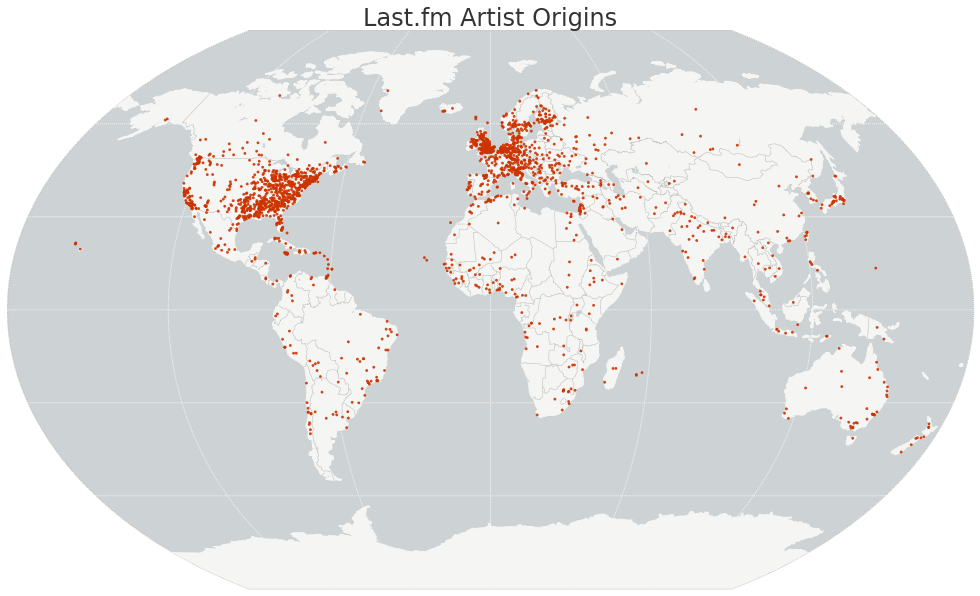

In [25]:
# create the plot
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, axisbg='#ffffff', frame_on=False)
ax.set_title('Last.fm Artist Origins', fontsize=24, color='#333333')

# draw the basemap and its features
m = Basemap(projection='kav7', lon_0=0, resolution='l', area_thresh=10000)
m.drawmapboundary(color=border_color, fill_color=water_color)
m.drawcoastlines(color=coastline_color)
m.drawcountries(color=border_color)
m.fillcontinents(color=land_color, lake_color=water_color)
m.drawparallels(np.arange(-90., 120., 30.), color=meridian_color)
m.drawmeridians(np.arange(0., 420., 60.), color=meridian_color)

# project our points from each dataset then concatenate and scatter plot them
x, y = m(lons.values, lats.values)
m.scatter(x, y, s=8, color=marker_fill_color, edgecolor=marker_edge_color, alpha=0.9, zorder=3)

# show the map
plt.savefig('images/lastfm_artists_origins_map.png', dpi=96, bbox_inches='tight', pad_inches=0.2)
plt.show()